# Title: Digit Recognizer

# Database: https://www.kaggle.com/competitions/digit-recognizer/overview

## Goal: 
* The goal in this competition is to take an image of a handwritten single digit, and determine what that digit is.
For every in the test set, you should predict the correct label.
## Evaluation:
* This competition is evaluated on the categorization accuracy of your predictions (the percentage of images you get correct).

In [1]:
import sys  
sys.path.insert(0, '../Utils/')

import ntfy

In [5]:
# Imports
## Data manage and plot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
## Modeling
from catboost import Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split
## Deep Modeling


# Lets compare Supervised models with Neural Networks

# Supervised test:

In [6]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [7]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(train_df.drop('label', axis=1), train_df['label'])

model = CatBoostRegressor(logging_level='Silent')
model.fit(X_train, y_train)

In [5]:
model.score(X_test, y_test)

0.8982814721150002

In [6]:
preds = model.predict(test_df)
preds

array([ 1.70230534, -0.43309995,  7.55466399, ...,  3.20529371,
        7.99197427,  1.86270634])

In [7]:
print(round(preds))

TypeError: type numpy.ndarray doesn't define __round__ method



# With NN from scratch
#
### We will have 2 layers with 784 units corresponding to 784 pixels for num image, this will be in format 28x28 matrix for each number
###
* First layer will be a hidden layer and will have 10 units with ReLU activation.
* Second layer will be a output layer and will have 10 units, corresponding to the 10 digits (0 - 9), with softmax activation.

In [11]:
# Setup data
data = np.array(train_df)
rows, cols = data.shape
np.random.shuffle(data) # shuffle before splitting into dev and training sets

test_data = data[0:1000].T # we transpose for 
y_test = test_data[0]
X_test = test_data[1:cols]
X_test = X_test / 255.

train_data = data[1000:rows].T
y_train = train_data[0]
X_train = train_data[1:cols]
X_train = X_train / 255.

In [12]:
# NN with 2 layers
def init_params():
    W1 = np.random.rand(10, 784) - 0.5 # weights1
    b1 = np.random.rand(10, 1) - 0.5 # bias1
    W2 = np.random.rand(10, 10) - 0.5 # weights2
    b2 = np.random.rand(10, 1) - 0.5 # bias2
    return W1, b1, W2, b2

def ReLU(Z): # returns 0 if the num is negative, else return the num
    return np.maximum(Z, 0)

def softmax(Z):
    return np.exp(Z) / sum(np.exp(Z))

def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1 # Z1 correspond to the first layer, X would be the input layer and b the bias
    A1 = ReLU(Z1) # A1 correspond to the first activation, in this case ReLU
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def one_hot(y):
    one_hot_y = np.zeros((y.size, y.max() + 1)) # create a matrix with zeros with the size of y
    one_hot_y[np.arange(y.size), y] = 1 # change the value position from 0 to 1 (Ex.: 3 -> [0, 0, 0, 1, 0, 0, 0, 0, 0, 0])
    one_hot_y = one_hot_y.T # T cause now each row is a example, and we want to be each columns
    return one_hot_y

def ReLU_deriv(Z):
    return Z > 0

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, y):
    rows = y.size
    one_hot_y = one_hot(y)
    # taking how much the second layer pred was off the true pred
    dZ2 = A2 - one_hot_y
    # calculate how much weights and bias contributed to the error
    dW2 = 1 / rows * dZ2.dot(A1.T)
    db2 = 1 / rows * np.sum(dZ2)
    # taking how much the second layer pred was off and apply to the first layer using deriv
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    # calculate how much weights and bias contributed to the error
    dW1 = 1 / rows * dZ1.dot(X.T)
    db1 = 1 / rows * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    # update the last params with the news applying the learning_rate
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    return W1, b1, W2, b2

In [13]:
# gradient_descent
def get_pred(A2):
    return np.argmax(A2, 0)
    
def get_accu(preds, true_values):
    return np.sum(preds == true_values) / true_values.size # sum the amount of true preds and / for the total
    
def gradient_descent(X, y, iterations, learning_rate):
    W1, b1, W2, b2 = init_params()
    last_accu = 0
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)
        if i % 100 == 0: # print every 500 iters
            accu = get_accu(get_pred(A2), y)
            print('Iteration: ', i)
            print(get_pred(A2), y)
            print('Accuracy: ', accu)
            if accu < last_accu: # stopper when accu goes down
                print('Stopping...')
                break
            last_accu = get_accu(get_pred(A2), y)
    ntfy.send_notification(f'Finish gradient_descent from scratch with a {last_accu} accuracy')
    return W1, b1, W2, b2

In [14]:
# test preds
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_pred(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2, X, y):
    current_image = X[:, index, None]
    prediction = make_predictions(X[:, index, None], W1, b1, W2, b2)
    label = y[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

In [15]:
W1, b1, W2, b2 = gradient_descent(X_train, y_train, 1000, 0.1)
get_accu(make_predictions(X_test, W1, b1, W2, b2), y_test)

Iteration:  0
[9 0 4 ... 9 4 5] [6 7 1 ... 4 9 1]
Accuracy:  0.08651219512195121
Iteration:  500
[6 7 1 ... 4 9 1] [6 7 1 ... 4 9 1]
Accuracy:  0.8477317073170731


0.873

In [35]:
get_accu(make_predictions(X_test, W1, b1, W2, b2), y_test)

0.924

Prediction:  [1]
Label:  1


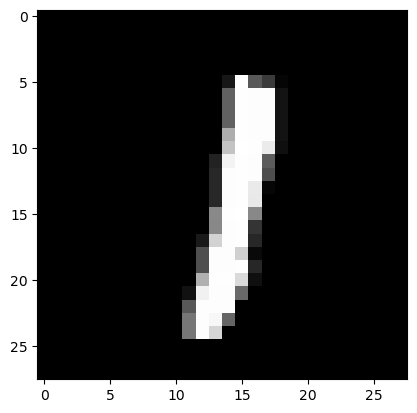

In [73]:
test_prediction(1, W1, b1, W2, b2, X_test, y_test)

In [61]:
def plot_decision_boundary(W1, b1, W2, b2, X, y):
    '''
    Plot the decision boundary created by a model predicting on X
    '''
    # Define the axis boundaries of the plot and create a meshgrid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    # Create X value (we're going to make predictions on these)
    x_in = np.c_[xx.ravel(), yy.ravel()] # stack 2D arrays together

    # Make predictions
    y_pred = make_predictions(X, W1, b1, W2, b2)

    # Check for multi-class
    if len(y_pred) > 1:
        print("doing multiclass classification...")
        # We have to reshape our predictions to get them ready for plotting
        y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)
    else:
        print("doing binary classification...")
        y_pred = np.round(y_pred).reshape(xx.shape)

    # Plot the decision boundary
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

In [62]:
plot_decision_boundary(W1, b1, W2, b2, X_test, y_test)

doing binary classification...


ValueError: cannot reshape array of size 1000 into shape (100,100)

In [76]:
np_test_df = np.array(test_df)
np_test_df = np_test_df.T
np_test_df = np_test_df / 255.

In [77]:
np_test_df.shape, X_train.shape

((784, 28000), (784, 41000))

In [78]:
preds = make_predictions(np_test_df, W1, b1, W2, b2)

In [79]:
preds

array([2, 0, 9, ..., 3, 9, 2])

# With NN

#

# Push results

In [80]:
sample_submission = pd.read_csv('sample_submission.csv', index_col=False)
sample_submission.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [81]:
len(preds), len(test_df.index)

(28000, 28000)

In [82]:
submission_df = pd.DataFrame({'ImageId':test_df.index+1, 'Label':preds})
submission_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,7
4,5,3


In [83]:
submission_df.to_csv('NN-from-scratch-2.csv', index=False)